In [1]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")
from sklearn.metrics import confusion_matrix as CM
import seaborn as sns

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [2]:
import os
os.getcwd()

'/content/drive/My Drive'

In [3]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [4]:
f = glob.glob("Colab Notebooks/NLP_cw2/swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [6]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [7]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [9]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [10]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [11]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [12]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [13]:
#### ME: WHAT DOES THE {'D', 'Well'} bit mean - basically how is this structured?

In [14]:
sentences[5]

['<laughter>.', '', '{D', 'Well,', '}', 'yeah', '', '/']

In [15]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [16]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


In [17]:
sentence_embeddings[0] ### how are these word embeddings exactly? are they the one hot labels of the types of responses?

[1, 2, 3, 4, 5, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

The dataset is divided into two sections: test and training.

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [19]:
MAX_LENGTH = 150

In [20]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [21]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [22]:
train_input[11050]


array([376,  97, 100, 577, 906,  24,  17,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [23]:
sentence_embeddings[11050]

[376, 97, 100, 577, 906, 24, 17]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [24]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [25]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

#Building the network
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, return_state=False)))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=False, return_state=False)))
model.add(Dense(43,activation='softmax'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4373200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 86)         49536     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 43)                3741      
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Train the model - use validation 
model.compile('adam','categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_input, y = train_labels, validation_data = (val_input, val_labels),epochs=5)

Epoch 1/5
4375/4375 [==============================] - 580s 131ms/step - loss: 1.2088 - accuracy: 0.6472 - val_loss: 1.0379 - val_accuracy: 0.6857
Epoch 2/5
4375/4375 [==============================] - 599s 137ms/step - loss: 0.8843 - accuracy: 0.7335 - val_loss: 0.9829 - val_accuracy: 0.6926
Epoch 3/5
4375/4375 [==============================] - 538s 123ms/step - loss: 0.7731 - accuracy: 0.7629 - val_loss: 0.9725 - val_accuracy: 0.6912
Epoch 4/5
4375/4375 [==============================] - 539s 123ms/step - loss: 0.6961 - accuracy: 0.7840 - val_loss: 0.9889 - val_accuracy: 0.6925
Epoch 5/5
4375/4375 [==============================] - 544s 124ms/step - loss: 0.6355 - accuracy: 0.8003 - val_loss: 1.0282 - val_accuracy: 0.6848


In [27]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 40s 71ms/step - loss: 0.9835 - accuracy: 0.7011


In [28]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)
print("Overall Accuracy:", score[1]*100)


560/560 [==============================] - 40s 71ms/step - loss: 0.9835 - accuracy: 0.7011
Overall Accuracy: 70.11018991470337


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

## Minority Classes

In [30]:
y_test.shape

(55902, 43)

In [31]:
# Generate predictions for the test data
#### looking at least common 14 classes
masks = (np.sum(y_test[:,30:43],axis=1) == 1)
y_minority = y_test[masks]
x_minority = test_sentences_X[masks]
minority_score = model.evaluate(x_minority, y_minority, batch_size=100)
print(minority_score)

43/43 [==============================] - 4s 87ms/step - loss: 1.5827 - accuracy: 0.6259
[1.5827194452285767, 0.6258757710456848]


In [32]:

y_minority_indexes = np.argmax(y_minority,axis=1)

43/43 [==============================] - 4s 81ms/step - loss: 1.5827 - accuracy: 0.6259
accuracy for minority_score:  0.6258757710456848


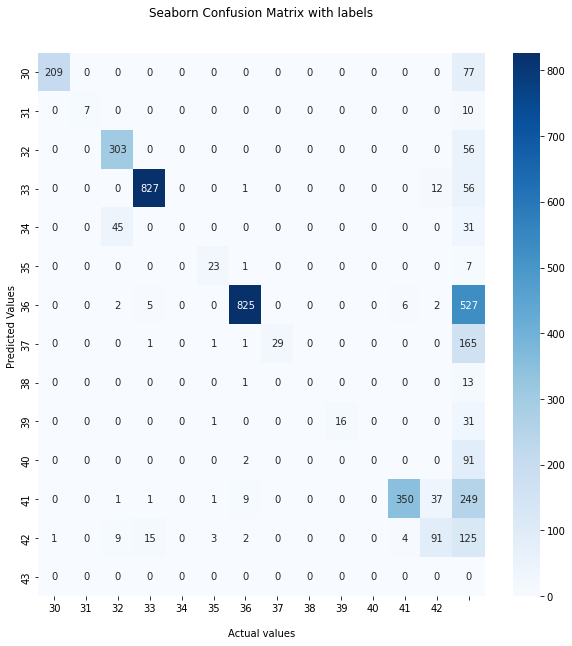

In [33]:

# Build the confusion matrix off these predictions
masks = (np.sum(y_test[:,30:43],axis=1) == 1)
y_minority = y_test[masks]
x_minority = test_sentences_X[masks]
minority_score = model.evaluate(x_minority, y_minority, batch_size=100)
print("accuracy for minority_score: ", minority_score[1])

predictions = np.argmax(model(x_minority),axis=1)
predictions_with_other = np.where(predictions < 30, 43, predictions)
cm = CM(y_minority_indexes, predictions_with_other)

plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(range(30,43,1)))
ax.yaxis.set_ticklabels(list(range(30,44,1)))

## Display the visualization of the Confusion Matrix.
plt.show()

In [34]:
# Calculate Accuracies for "br" and "bf"
mapper = {'bf' : 20, 'br' : 30}
masks = y_test[:,20]+y_test[:,30] == 1
y_bf_br = y_test[masks]
x_bf_br = test_sentences_X[masks]
bf_br_score = model.evaluate(x_bf_br, y_bf_br, batch_size=100)
print("accuracy for minority_score: ", bf_br_score[1])

7/7 [==============================] - 1s 76ms/step - loss: 1.5331 - accuracy: 0.5332
accuracy for minority_score:  0.5332303047180176


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [35]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


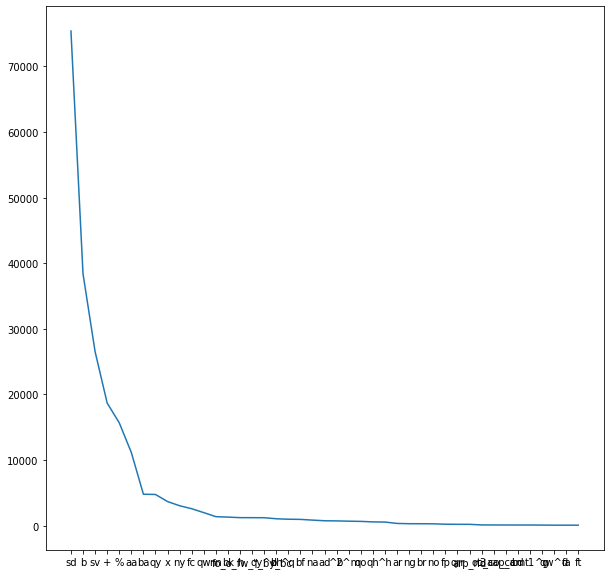

In [36]:
# Plot the frequencies of the classes
fig = plt.figure(figsize=(10,10))
plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [37]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [38]:
# Re-built the model for the balanced training
#Building the network
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, return_state=False)))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=False, return_state=False)))
model.add(Dense(43,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         4373200   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 86)         49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


## Test the model

In [39]:
model.fit(x=train_input, y = train_labels, validation_data = (val_input, val_labels),epochs=5,class_weight=d_class_weights)
score = model.evaluate(test_sentences_X, y_test, batch_size=100)
print("Overall Accuracy:", score[1]*100)
# Generate predictions for the test data
label_pred = model.predict(test_sentences_X, batch_size=100)

Epoch 1/5
4375/4375 [==============================] - 667s 151ms/step - loss: 2.6850 - accuracy: 0.3371 - val_loss: 2.1795 - val_accuracy: 0.4013
Epoch 2/5
4375/4375 [==============================] - 624s 143ms/step - loss: 1.8907 - accuracy: 0.4243 - val_loss: 1.8659 - val_accuracy: 0.4664
Epoch 3/5
4375/4375 [==============================] - 614s 140ms/step - loss: 1.5524 - accuracy: 0.4606 - val_loss: 1.9765 - val_accuracy: 0.4250
Epoch 4/5
4375/4375 [==============================] - 628s 144ms/step - loss: 1.3113 - accuracy: 0.4846 - val_loss: 1.9132 - val_accuracy: 0.4291
Epoch 5/5
560/560 [==============================] - 44s 79ms/step - loss: 1.8586 - accuracy: 0.4338
Overall Accuracy: 43.377697467803955


In [40]:
# Generate predictions for the test data


## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [41]:
label_pred = model.predict(test_sentences_X, batch_size=100)
label_predsidx = np.argmax(label_pred,axis=1)


In [43]:
#30-43
masks = (np.sum(y_test[:,30:43],axis=1) == 1)
y_minority = y_test[masks]
x_minority = test_sentences_X[masks]
minority_score = model.evaluate(x_minority, y_minority, batch_size=100)
print("accuracy for minority_score: ", minority_score[1])

43/43 [==============================] - 4s 104ms/step - loss: 1.3568 - accuracy: 0.6625
accuracy for minority_score:  0.662540853023529


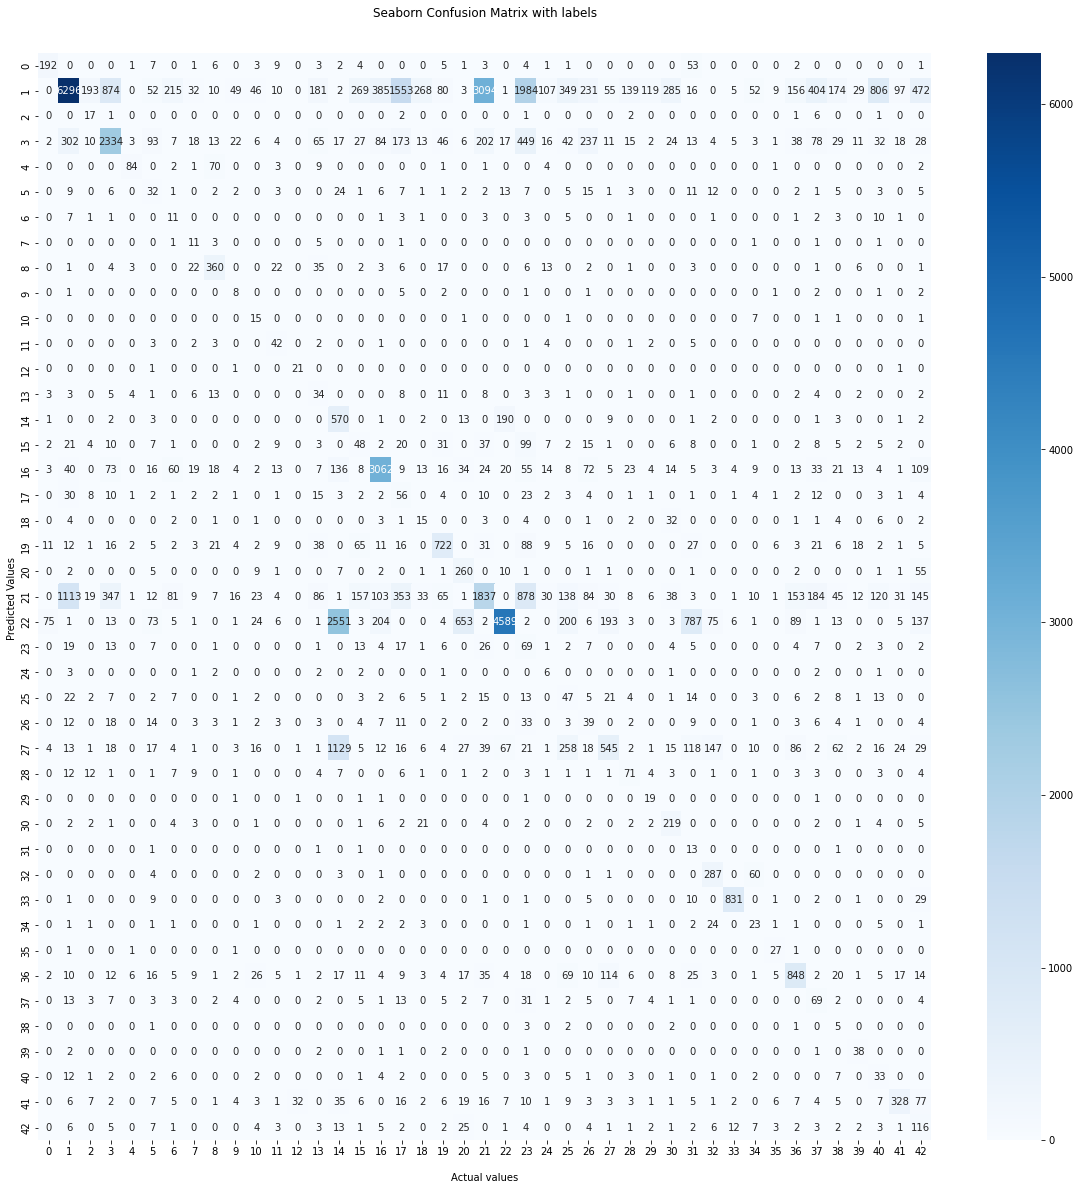

7/7 [==============================] - 1s 96ms/step - loss: 1.0951 - accuracy: 0.7403
accuracy for minority_score:  0.7403400540351868


In [42]:

y_idx = np.argmax(y_test,axis=1)
cm = CM(y_idx, label_predsidx)

plt.figure(figsize=(20,20))
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(range(0,43,1)))
ax.yaxis.set_ticklabels(list(range(0,43,1)))

## Display the visualization of the Confusion Matrix.
plt.show()


# Calculate Accuracies for "br" and "bf"
mapper = {'bf' : 20, 'br' : 30}
masks = y_test[:,20]+y_test[:,30] == 1
y_bf_br = y_test[masks]
x_bf_br = test_sentences_X[masks]
bf_br_score = model.evaluate(x_bf_br, y_bf_br, batch_size=100)
print("accuracy for minority_score: ", bf_br_score[1])







### Explanation



### Other ways to handle imbalanced classes




Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [44]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Input,LSTM
from tensorflow.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

In [45]:
#Checking model up to this stage
# mod = Model(inputs=[inputs], outputs=[maxpool_1, maxpool_2, maxpool_0])
# mod.summary()

In [46]:
##### concatenate the poooled tensors together
# concatenate tensors
cats = tf.concat([maxpool_0, maxpool_1,maxpool_2],axis=-1)
# flatten concatenated tensors
flatcats = Reshape((-1,192))(cats) # dim 2
#put through a dense layer to get our first pre-final section output.
post_dense = Dense(units=EMBED_SIZE,input_shape=(1,),activation='relu')(flatcats) # dim 2
# dropout_1
first_pre_final = Dropout(drop)(post_dense)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [47]:
#### HERE - put the first pre final thing through the BILSTM before joining it back together later.


# Bidirectional 1
x = Bidirectional(LSTM(EMBED_SIZE,return_sequences=True))(first_pre_final)
# Bidirectional 2
x = Bidirectional(LSTM(EMBED_SIZE,return_sequences=False))(x)
# Dense layer (dense_2)
x = Dense(EMBED_SIZE,'relu')(x)
# dropout_2
post_bilstm = Dropout(drop)(x)


Concatenate 2 last layers and create the output layer
network

In [48]:
#AGAIN: just checking the model structure at this point.
# mod = Model(inputs=[inputs], outputs=[post_bilstm,first_pre_final])
# mod.summary()

In [49]:
reshapedx = Reshape((100,))(first_pre_final)
cats2 = tf.concat((post_bilstm, reshapedx),-1)
x = Dense(HIDDEN_SIZE,'softmax')(cats2)

mod = Model(inputs=[inputs], outputs=[x])
mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 100)     4373200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                              

In [ ]:
##### REFERENCE MODEL


Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 100)     4373200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                             

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [52]:
# Train the model - use validation 
mod.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])
mod.fit(x=train_input, y = train_labels, validation_data = (val_input, val_labels),epochs=12)
score = mod.evaluate(test_sentences_X, y_test, batch_size=100)
print("Overall Accuracy:", score[1]*100)
# Generate predictions for the test data
label_pred = mod.predict(test_sentences_X, batch_size=100)

Epoch 1/12
4375/4375 [==============================] - 220s 49ms/step - loss: 0.9742 - accuracy: 0.6850 - val_loss: 1.1522 - val_accuracy: 0.6630
Epoch 2/12
4375/4375 [==============================] - 203s 46ms/step - loss: 0.8281 - accuracy: 0.7325 - val_loss: 1.1249 - val_accuracy: 0.6784
Epoch 3/12
4375/4375 [==============================] - 199s 46ms/step - loss: 0.7340 - accuracy: 0.7639 - val_loss: 1.1669 - val_accuracy: 0.6690
Epoch 4/12
4375/4375 [==============================] - 188s 43ms/step - loss: 0.6653 - accuracy: 0.7888 - val_loss: 1.2135 - val_accuracy: 0.6754
Epoch 5/12
4375/4375 [==============================] - 190s 44ms/step - loss: 0.6110 - accuracy: 0.8065 - val_loss: 1.2617 - val_accuracy: 0.6652
Epoch 6/12
4375/4375 [==============================] - 187s 43ms/step - loss: 0.5671 - accuracy: 0.8208 - val_loss: 1.3144 - val_accuracy: 0.6753
Epoch 7/12
4375/4375 [==============================] - 184s 42ms/step - loss: 0.5368 - accuracy: 0.8310 - val_loss: 1

In [53]:
mapper = {'bf' : 20, 'br' : 30}
masks = y_test[:,20]+y_test[:,30] == 1
y_bf_br = y_test[masks]
x_bf_br = test_sentences_X[masks]
bf_br_score = mod.evaluate(x_bf_br, y_bf_br, batch_size=100)
print("accuracy for minority_score: ", bf_br_score[1])



7/7 [==============================] - 0s 12ms/step - loss: 2.0702 - accuracy: 0.5240
accuracy for minority_score:  0.5239567160606384


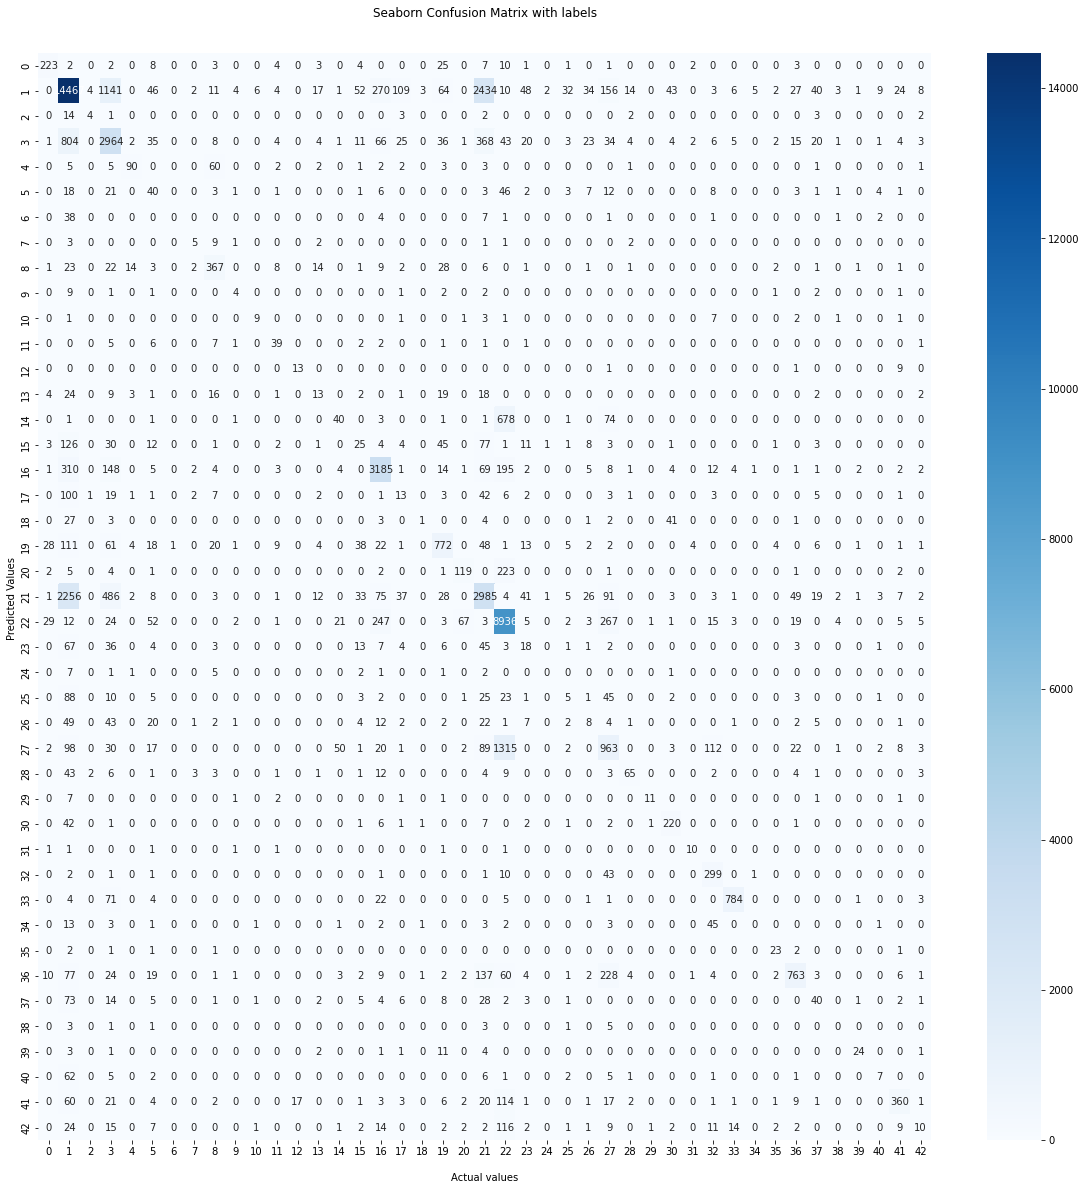

7/7 [==============================] - 0s 67ms/step - loss: 1.0951 - accuracy: 0.7403
accuracy for minority_score:  0.7403400540351868


In [54]:
### Frequent errors
label_pred = mod.predict(test_sentences_X, batch_size=100)
label_predsidx = np.argmax(label_pred,axis=1)

y_idx = np.argmax(y_test,axis=1)
cm = CM(y_idx, label_predsidx)

plt.figure(figsize=(20,20))
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(range(0,43,1)))
ax.yaxis.set_ticklabels(list(range(0,43,1)))

## Display the visualization of the Confusion Matrix.
plt.show()


# Calculate Accuracies for "br" and "bf"
mapper = {'bf' : 20, 'br' : 30}
masks = y_test[:,20]+y_test[:,30] == 1
y_bf_br = y_test[masks]
x_bf_br = test_sentences_X[masks]
bf_br_score = model.evaluate(x_bf_br, y_bf_br, batch_size=100)
print("accuracy for minority_score: ", bf_br_score[1])



In [55]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 67.84014701843262
